In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

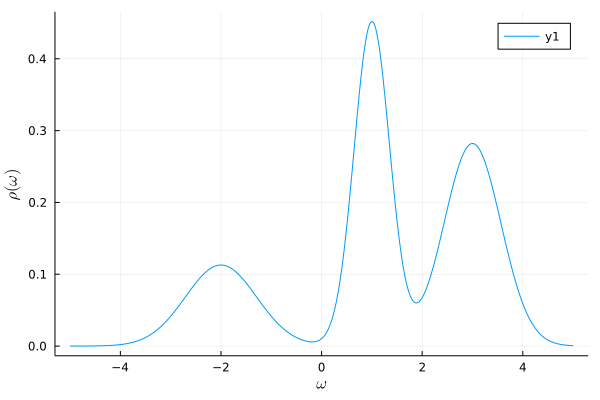

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 


#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

38

In [8]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [9]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [18]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H         =  50
ab_coeff  = zeros(ComplexF64, 2*H) 
lambda    = 1e-5
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

┌ Error: Failed to revise /home/kosuke/work/Nevanlinna_f/src/schur.jl
│   exception = (LoadError("/home/kosuke/work/Nevanlinna_f/src/schur.jl", 1, "\"<<\" is not a unary operator"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f34e25a378a])
└ @ Revise /home/kosuke/.julia/packages/Revise/VskYC/src/packagedef.jl:710
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/kosuke/work/Nevanlinna_f/src/schur.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /home/kosuke/.julia/packages/Revise/VskYC/src/packagedef.jl:818


N_imag is setted as 33
N_imp 33


In [19]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, lambda, true)
;

Pick matrix is positive semi-definite.
H= 1
Iter     Function value   Gradient norm 
     0     5.268531e-02     2.853460e-01
 * time: 0.00020885467529296875
     1     1.557003e-02     2.944789e-02
 * time: 0.2646028995513916
     2     9.936066e-03     3.745669e-02
 * time: 0.7554190158843994
     3     7.767061e-03     1.607570e-02
 * time: 1.0922448635101318
     4     7.557263e-03     1.109372e-03
 * time: 1.4867010116577148
     5     7.555119e-03     3.938569e-05
 * time: 1.8575029373168945
     6     7.555108e-03     3.760330e-06
 * time: 2.1567559242248535
     7     7.555108e-03     8.361623e-07
 * time: 2.64872407913208
     8     7.555108e-03     8.616084e-08
 * time: 3.0638749599456787
     9     7.555108e-03     4.028217e-09
 * time: 3.387734889984131
max_theta=0.232645042161245842531767674602569116360802553626864006081219172955777014299669388497442978638039777692006984768875754826491303832272953228248281272620147913
hardy optimization was success.
max_theta=0.0
hardy opt

In [20]:
@time Nevanlinna.solve(sol)

H= 1
Iter     Function value   Gradient norm 
     0     5.268531e-02     2.853460e-01
 * time: 0.00021004676818847656
     1     1.557003e-02     2.944789e-02
 * time: 0.26712608337402344
     2     9.936066e-03     3.745669e-02
 * time: 0.7622520923614502
     3     7.767061e-03     1.607570e-02
 * time: 1.1834659576416016
     4     7.557263e-03     1.109372e-03
 * time: 1.657027006149292
     5     7.555119e-03     3.938569e-05
 * time: 2.122230052947998
     6     7.555108e-03     3.760330e-06
 * time: 2.376223087310791
     7     7.555108e-03     8.361623e-07
 * time: 2.7211410999298096
     8     7.555108e-03     8.616084e-08
 * time: 3.05845308303833
     9     7.555108e-03     4.028217e-09
 * time: 3.3046789169311523
max_theta=0.232645042161245842531767674602569116360802553626864006081219172955777014299669388497442978638039777692006984768875754826491303832272953228248281272620147913
hardy optimization was success.
H= 2
Iter     Function value   Gradient norm 
     0     7.5551

In [21]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


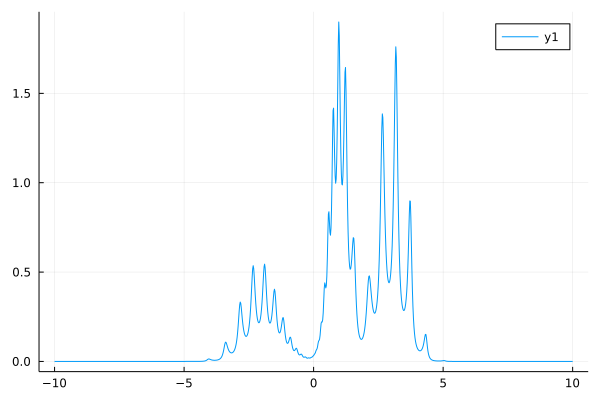

In [22]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))
#plot!(omegas, rho.(omegas))

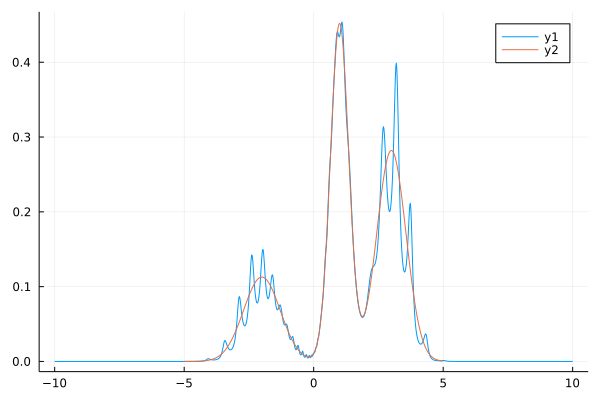

In [23]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [16]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [17]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#